## Question 1

### Simulating from a state-space model with 4 age classes

Subprocesses: survival, ageing, reproduction

$\bullet$ First year individuals don't reproduce

$\bullet$ First year individuals survive with probability $\phi_{1} = 0.45$

$\bullet$ Second year individuals survive with probability $\phi_{2} = 0.7$ 

$\bullet$ Second year individuals reproduce at rate $\rho_{1} = 0.9$

$\bullet$ Third year individuals survive with probability $\phi_{3} = 0.7$

$\bullet$ Third year individuals reproduce at rate $\rho_{2} = 1.9$

$\bullet$ Fourth year individuals die and don't reproduce.

Individuals are detected with probability $p=0.5$.

Initial age distribution $(150, 70, 50, 30)$.

#### Survival Distributions:

$$
    \begin{pmatrix}
    u_{1(s), 1, t} \sim Bin(n_{1, t-1}, \phi_{1}) \\
    u_{1(s), 2, t} \sim Bin(n_{2, t-1}, \phi_{2}) \\
    u_{1(s), 3, t} \sim Bin(n_{3, t-1}, \phi_{3}) \\
    u_{1(s), 4, t} = 0 \\
    \end{pmatrix}
$$
    
####  Growth
Given that we're modelling age classes, we assume that all individuals at a particular age will grow to the next age. 

$$
    \begin{pmatrix}
    u_{2(r), 1, t} = 0 \\
    u_{2(r), 2, t} = u_{1(s), 1, t} \\
    u_{2(r), 3, t} = u_{1(s), 2, t} \\
    u_{2(r), 4, t} = u_{1(s), 3, t} \\
    \end{pmatrix}
$$

####  Reproduction
$$
    \begin{pmatrix}
    u_{3(b), 1, t} = Pois(u_{2(r),2,t}\rho_{1}) + Pois(u_{2(r),3,t}\rho_{2}) \\
    u_{3(b), 2, t} = u_{2(r), 2, t} \\
    u_{3(b), 3, t} = u_{2(r), 3, t} \\
    u_{3(b), 4, t} = u_{2(r), 4, t} \\
    \end{pmatrix}
$$


In [68]:
project_population = function(years, n0, phi, rho, p) {
    projections = matrix(NA, 4, years)
    projections[, 1] = n0
    y = matrix(NA, 4, years)
    
    # initial observation
    for (age in 1: 4) {
        y[age, 1] = rbinom(n=1, size=projections[age, 1], prob=p)
    }
        
    for (year in 2:years) {
        
        # sub-process 1, survival
        s1 = rbinom(n=1, size=projections[1, year - 1], prob=phi[1])
        s2 = rbinom(n=1, size=projections[2, year - 1], prob=phi[2])
        s3 = rbinom(n=1, size=projections[3, year - 1], prob=phi[3])
        s4 = 0
        
        # sub-process 2, growth
        r1 = 0
        r2 = s1
        r3 = s2
        r4 = s3
        
        #sub-process 3, birth
        b1 = rpois(n=1, lambda=r2 * rho[1]) + rpois(n=1, lambda=r3 * rho[2])
        b2 = r2
        b3 = r3
        b4 = r4
        
        projections[1, year] = b1
        projections[2, year] = b2
        projections[3, year] = b3
        projections[4, year] = b4
        
        # population observation
        for (age in 1:4) {
            y[age, year] = rbinom(n=1, size=projections[age, year], prob=p)
        }
        
    }
    #return(projections)
    return(data.frame(
        Year = 1:years,
        Abundance = c(
            projections[1, ], y[1, ],
            projections[2, ], y[2, ],
            projections[3, ], y[3, ],
            projections[4, ], y[4, ]),
        Type = rep(c("State","Observation"), each=years, times=4),
        Classes = rep(c(
            "Age 1", "Age 2", "Age 3", "Age 4"), each=2 * years)
        )
    )
}

In [69]:
projected_population = project_population(
    years=25, 
    n0=c(150, 70, 50, 30),
    phi=c(0.45, 0.7, 0.7),
    rho=c(0.9, 1.9),
    p=0.5
)

In [17]:
options(warn=-1)
library(ggplot2)
library(ggthemes)

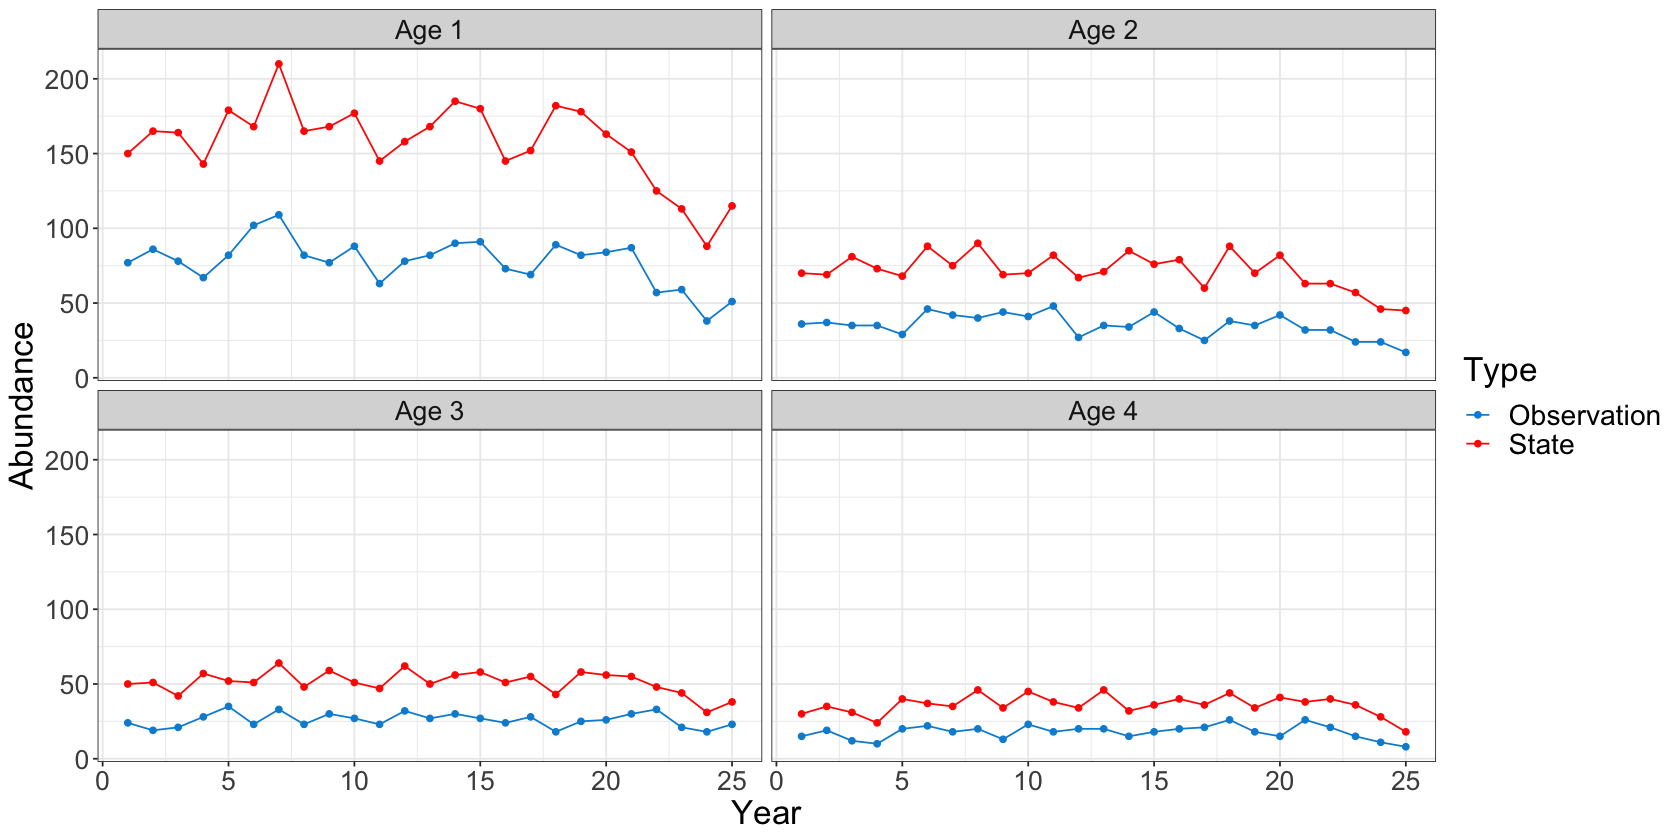

In [101]:
options(repr.plot.width=14, repr.plot.height=7)
ggplot(data=projected_population, aes(x=Year, y=Abundance, group=Type, color=Type, fill=Type)) + 
  geom_line() +
  geom_point(aes(type=Classes)) + 
  facet_wrap(.~Classes) + 
  theme_bw() + 
  scale_color_fivethirtyeight() +
  scale_fill_fivethirtyeight() +
  theme(
    legend.text=element_text(size=17),
    text = element_text(size = 20)   
  )

## Question 2

##### A. 

In case the removal happens before the growth we need to substract the removed quantity from the population size before we calculate the next population size. 
That can be done in the following way:

$$ N_{t-1} = N_{t-1} - c_{t-1} $$
$$ N_{t} = N_{t-1} + rN_{t-1}(1 - \frac{N_{t-1}}{K})$$

##### B.

If we model the growth rate _r_ as a function of rainfall at the time _t-1_, we're assuming that the rainfall from previous iteration is going to influence the rate at this iteration. In biological terms, rainfall last year could increase the food available so there could be more offsprings per capita. 

If the growth rate is a function of rainfall at time _t_ it could mean that rainfall could benefit the survival rate of offsprings produced. This could mean that the rainfall at time _t-1_ is influencing the adults in the population while the rainfal at time _t_ is influencing the offsprings.

##### C.

Carrying capacity as a function of rainfall at _t-1_ can increase the vegetation available for the next generation. This can lead to an increase in carrying capacity at current time. 

If we model the carrying capacity as a function of rainfall at time _t_ we assume that current rainfalls have a direct impact on the carrying capacity, rather than a lagged one as in the previous case. A reasoning for this could be the fact that there is more water available for the population so wilderbeets need to do less migration for water. 


### Question 3

In [2]:
library(statsecol)
data(wildebeest)

##### A.

In [88]:
logistic_model =  function(pars, years, removals, Nhat, SEhat, rain, lag) {
    N = numeric(years)
    N[1] = exp(pars[1])
    K = exp(pars[2])
    
    for (year in 2:years) {
        r  = exp(pars[3] + pars[4] * rain[year - lag])
        N[year] = N[year - 1] + r * N[year - 1] *(1 - N[year - 1]/K) - removals[year - 1]
    }
    
    negloglik <- -sum(dnorm(Nhat,N,SEhat,log=TRUE), na.rm=TRUE)
    
    return (negloglik)
}

In [89]:
fit_prev_year <- optim(
    par = c(log(0.1),log(0.25),0, 0), 
    fn = logistic_model, 
    years = nrow(wildebeest), 
    removals = wildebeest$Catch, 
    Nhat = wildebeest$Nhat, 
    SEhat = wildebeest$sehat, 
    rain = wildebeest$rain,
    lag=1
)
fit_current_year <- optim(
    par = c(log(0.1),log(0.25),0, 0), 
    fn = logistic_model, 
    years = nrow(wildebeest), 
    removals = wildebeest$Catch, 
    Nhat = wildebeest$Nhat, 
    SEhat = wildebeest$sehat, 
    rain = wildebeest$rain,
    lag=0
)


In [90]:
parameters <- data.frame(
    Parameter = c("alpha0", "alpha1"),
    Prev.Year = c(round(fit_prev_year$par[3], 2), round(fit_prev_year$par[4], 2)),
    Current.Year = c(round(fit_current_year$par[3], 2), round(fit_current_year$par[4], 2))
)
parameters

Parameter,Prev.Year,Current.Year
<chr>,<dbl>,<dbl>
alpha0,-2.34,-2.98
alpha1,0.16,0.63


It looks like modelling the growth rate at time _t-1_ shows that the growth rate is increasing by 0.16 for every 1 $cm^2$ increase in the rainfall while modelling the growth rate at time _t_ the growth rate increases by 0.63 for every 1 $cm^2$ increase in rainfall. The growth rate as a function of rain at time _t_ is greater than the growth rate as a function of rain at time _t-1_. This means that the rainfall at current time is more beneficial than the rainfall in previous season, for growth, potentially because it eases up the conditions during the dry season.

In [91]:
AIC_no_lag = 2 * fit_current_year$value + 2 * 4
AIC_lag = 2 * fit_prev_year$value + 2 * 4
data.frame(Model = c("r(t-1)","r(t)"),
    K = c(4, 4),
    nll = c(fit_prev_year$value, fit_current_year$value),
    AIC = c(AIC_lag, AIC_no_lag),
    dAIC = c(AIC_lag, AIC_no_lag)- min(c(AIC_lag, AIC_no_lag)))

Model,K,nll,AIC,dAIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
r(t-1),4,-12.57291,-17.14582,1.821001
r(t),4,-13.48341,-18.96683,0.000000


The model that is defining growth rate as a function of rain at current time has a better AIC value and based only on this value, we would pick this model in favor of the other one. Given that the number of parameters is equal for both models, it means that the model with growth rate as a function of rainfall at time t is a better fit for the data. 

##### B.

Now fit two formulations of the time varying carrying capacity model, one where Kt is modelled as a function of rain is the same year (Rt) and another where Kt is modelled as a function of rain is the previous year (Rt−1). In both cases, hold r constant.
comparing the estimates of β1 between the two models - what do we learn?
comparing the two models using AIC, which is the preferred model, and why?


In [92]:
logistic_model_CC =  function(pars, years, removals, Nhat, SEhat, rain, lag) {
    N = numeric(years)
    N[1] = exp(pars[1])
    r = exp(pars[2])
    
    for (year in 2:years) {
        K  = exp(pars[3] + pars[4] * rain[year - lag])
        N[year] = N[year - 1] + r * N[year - 1] *(1 - N[year - 1]/K) - removals[year - 1]
    }
    
    negloglik <- -sum(dnorm(Nhat,N,SEhat,log=TRUE), na.rm=TRUE)
    
    return (negloglik)
}

In [98]:
fit_prev_year_CC <- optim(
    par = c(log(0.1),log(0.25),0, 0), 
    fn = logistic_model_CC, 
    years = nrow(wildebeest), 
    removals = wildebeest$Catch, 
    Nhat = wildebeest$Nhat, 
    SEhat = wildebeest$sehat, 
    rain = wildebeest$rain,
    lag=1
)
fit_current_year_CC <- optim(
    par = c(log(0.1),log(0.25),0, 0), 
    fn = logistic_model_CC, 
    years = nrow(wildebeest), 
    removals = wildebeest$Catch, 
    Nhat = wildebeest$Nhat, 
    SEhat = wildebeest$sehat, 
    rain = wildebeest$rain,
    lag=0
)

In [99]:
parameters <- data.frame(
    Parameter = c("alpha0", "alpha1"),
    Prev.Year = c(round(fit_prev_year_CC$par[3], 2), round(fit_prev_year_CC$par[4], 2)),
    Current.Year = c(round(fit_current_year_CC$par[3], 2), round(fit_current_year_CC$par[4], 2))
)
parameters

Parameter,Prev.Year,Current.Year
<chr>,<dbl>,<dbl>
alpha0,1.01,-0.55
alpha1,-0.03,1.04


Modelling carrying capacity as a function of rainfall at times _t_ and _t-1_ shows that there's almost no correlation between the carrying capacity and rainfall at time _t-1_ (alpha1 -0.03). At time _t_ there's a growth of 1.04 in carrying capacity for every 1 $cm^2$ of rainfall. Rainfall at time _t-1_ doesn't bring benefit for carrying capacity while at time t shows a positive correlation.

In [100]:
AIC_no_lag = 2 * fit_current_year_CC$value + 2 * 4
AIC_lag = 2 * fit_prev_year_CC$value + 2 * 4
data.frame(Model = c("r(t-1)","r(t)"),
    K = c(4, 4),
    nll = c(fit_prev_year$value, fit_current_year$value),
    AIC = c(AIC_lag, AIC_no_lag),
    dAIC = c(AIC_lag, AIC_no_lag)- min(c(AIC_lag, AIC_no_lag)))

Model,K,nll,AIC,dAIC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
r(t-1),4,-12.57291,-17.08316,2.903462
r(t),4,-13.48341,-19.98662,0.000000


The model where the carrying capacity is a function of rainfall at time _t_ has a better AIC value. This model is giving a better fit for the data and we should use this one in favor of the other one.